In [14]:
from google.colab import drive
drive.mount('/content/drive')
! pip install configargparse
! pip install wandb
! pip install open3d
! pip install lpips

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch

import open3d as o3d
import os

import sys
#sys.path.append('../')
sys.path.append('drive/Othercomputers/MacBookPro/')
import Rendering.visualization as v
import utils.data as data


In [16]:
def visualize_dataset(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = data.NeRFDataset(args)
    
    '''mesh = o3d.io.read_triangle_mesh(args.mesh, print_progress=True)
    mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)'''
    dataset.switch_2_xnv_dataset()

    #for subdataset in dataset.subdatasets:
    for subdataset in [d for d in dataset.subdatasets if d.name == "val"]:
        imgfiles = [os.path.join(args.dataset_path, subdataset.name, f) for f in sorted(os.listdir(os.path.join(args.dataset_path, subdataset.name))) if f.endswith('JPG') or f.endswith('jpg') or f.endswith('png')]

        for i in range(subdataset.n_images):
            xnv, img, depths = dataset.get_X_target(subdataset.name, i, device=device)
            v.dataset_view_rgb_xnv(img.detach().cpu(), 
                                    (dataset.hwf[0], dataset.hwf[1], 3), 
                                    xnv[..., :3].detach().cpu(), 
                                    xnv[..., 3:6].detach().cpu(), 
                                    xnv[..., 6:].detach().cpu())

In [17]:
class Args:
    def __init__(self):
        self.mesh_path = "drive/Othercomputers/MacBookPro/lego/meshed-poisson.ply" #"../data/lego_llff/meshed-delaunay.ply"
        self.dataset_path = "drive/Othercomputers/MacBookPro/lego" #"../data/lego_llff"
        self.dataset_type = "llff"
        self.factor = 1
        self.batch_size = 8192
        self.shuffle = True
        self.test = True
        self.dataset_to_gpu = False
        self.train_images=0
        self.val_images = 20
        self.test_images= 0

visualize_dataset(Args())


Output hidden; open in https://colab.research.google.com to view.

In [106]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def crop_image(path, saveas):
    img = cv2.imread(path)
    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))
    
    img = cv2.cvtColor(img[250:450, 350:550], cv2.COLOR_BGR2RGB)
    im = Image.fromarray(img)
    im.save(saveas)
    plt.imshow(im)
    plt.show()
    
'''def crop_image(path, saveas):
    im = Image.open(path)
    im = np.array(im)
    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))
    
    #img = cv2.cvtColor(img[240:475, 275:510], cv2.COLOR_BGR2RGB)
    im = Image.fromarray(im[250:550, 250:550])
    im.save(saveas)
    plt.imshow(im)
    plt.show()'''

'def crop_image(path, saveas):\n    im = Image.open(path)\n    im = np.array(im)\n    #img = np.concatenate((np.zeros((32, 500, 3), dtype=np.uint8)*255, img[:,150:650,:], np.zeros((32, 500, 3), dtype=np.uint8)*255))\n    \n    #img = cv2.cvtColor(img[240:475, 275:510], cv2.COLOR_BGR2RGB)\n    im = Image.fromarray(im[250:550, 250:550])\n    im.save(saveas)\n    plt.imshow(im)\n    plt.show()'

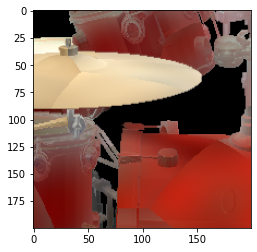

"crop_image(f'../Rendering/out/reflectance_drums_light_sphharm/-1degrees/val_reflectance_1_diffuse_it512.png',\n        '../../Thesis/Images/drums_nospharm_diffuse_crop.png')"

In [116]:
#for i in [8, 64, 125, 512]: 
#for img in ["specular", "diffuse", "reflectance"]:
crop_image(f'../Rendering/out/clusterised_radiance_drums/6freqs/val_xnv_pred_it64.png',
        f'../../Thesis/Images/drums_6freqs_precise_crop_64.png')

'''crop_image(f'../data/drums/val/r_100.png',
        f'../../Thesis/Images/drums_target_crop.png')'''

'''crop_image(f'../Rendering/out/reflectance_drums_light_sphharm/-1degrees/val_reflectance_1_diffuse_it512.png',
        '../../Thesis/Images/drums_nospharm_diffuse_crop.png')'''

In [21]:
import json
import seaborn as sns
import pandas as pd

def data_posenc_sphharm():
    data = {
        "PSNR": [],
        "SSIM": [],
        "LPIPS": [],
        "Scene": [],
        "Encoding": [],
        "Num. Clusters": []
    }
    for scene in ["drums", "microphone", "lego"]:
        path_posenc = f"../Rendering/out/reflectance_{scene}_light_posenc_XH"
        path_sphharm = f"../Rendering/out/reflectance_{scene}_light_sphharm/"
        
        for path, method in zip([path_posenc, path_sphharm], ["Pos. Enc.", "SH"]):
            for num_clusters in [8, 64, 125, 512]:
                with open(f"{path}/val_results_{num_clusters}clusters.json", "r") as json_file:
                    json_data = json.load(json_file)
                    data["PSNR"].append(json_data["psnr_mean"])
                    data["SSIM"].append(json_data["ssim_mean"])
                    data["LPIPS"].append(json_data["lpips_mean"])
                    data["Scene"].append(scene)
                    data["Num. Clusters"].append(num_clusters)
                    data["Encoding"].append(method)

    return pd.DataFrame(data=data)

posenc_sphharm_df = data_posenc_sphharm()

In [23]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False
})

sns.set_theme(style="whitegrid")

fig=plt.figure(figsize=(3.3,2.2))
plt.ylim(0, 28)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="PSNR", hue="Scene", style="Encoding")
gfg.get_legend().remove()
ax2 = gfg.twinx()
ax2.set_ylim(0,1)
ax2 = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="LPIPS", hue="Scene", style="Encoding", ax=ax2)
ax2.get_legend().remove()
fig.tight_layout(pad=.5)
plt.savefig("PSNR_LPIPS_SH_posenc.pgf")

fig=plt.figure(figsize=(2.5,2.2))
plt.ylim(0, 1)
gfg = sns.lineplot(data=posenc_sphharm_df, x="Num. Clusters", y="SSIM", hue="Scene", style="Encoding")
fig.tight_layout(pad=.5)
gfg.legend(fontsize=7)
plt.savefig("SSIM_SH_posenc.pgf")

In [225]:
posenc_sphharm_df

,psnr,ssim,lpips,scene,method,num_clusters
0,15.848844,0.216167,0.367531,drums,posenc,8
1,18.133343,0.217460,0.340638,drums,posenc,64
2,18.409909,0.218067,0.339968,drums,posenc,125
3,19.089567,0.223768,0.337501,drums,posenc,512
4,16.269224,0.709240,0.323268,drums,sphharm,8
5,19.266993,0.721865,0.282352,drums,sphharm,64
6,19.931775,0.726731,0.277187,drums,sphharm,125
7,21.010893,0.738699,0.270333,drums,sphharm,512
8,14.981794,0.811396,0.375853,lego,posenc,8
9,15.518263,0.816308,0.354721,lego,posenc,64
